In [1]:
#import modules
import pandas as pd
import numpy as np
import re

# Custom preprocessing function
from utils import preprocess_text


# Vectorization methods
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
#read csv that includes stock data
transcribed_list= pd.read_csv('transcribed_transcript_list2.csv')
transcribed_list.head(10)
print(transcribed_list['transcript'][0])

Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conference Call October 29, 2020  5:00 PM ET
Company Participants 
Tejas Gala - Senior Manager, Corporate Finance and Investor Relations
Tim Cook - Chief Executive Officer
Luca Maestri - Senior Vice President and Chief Financial Officer
Conference Call Participants
Shannon Cross - Cross Research
Jeriel Ong - Deutsche Bank
Katy Huberty - Morgan Stanley
Amit Daryanani - Evercore
Samik Chatterjee - JP Morgan
Krish Sankar - Cowen and Company
Kyle McNealy - Jefferies
Chris Caso - Raymond James
Operator
Good day everyone and welcome to the Apple Inc. Fourth Quarter Fiscal Year 2020 Earnings Conference Call. Today’s call is being recorded.
At this time for opening remarks and introductions, I would like to turn things over to Tejas Gala, Senior Analyst, Corporate Finance and Investor Relations. Please go ahead, sir.
Tejas Gala
Thank you. Good afternoon and thank you for joining us. Speaking first today is Apple’s CEO, Tim Cook, and he will be followed

In [3]:
#transcript_prep_remarks
transcribed_list.head(5)

,Unnamed: 0,date,ticker,title,transcript,transcript_prep_remarks,url
0,0,10/29/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q4 2020 Resu...,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,"['Operator', 'Good day everyone and welcome to...",/article/4382943-apple-inc-aapl-ceo-tim-cook-o...
1,1,7/30/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q3 2020 Resu...,Apple Inc. (NASDAQ:AAPL) Q3 2020 Results Confe...,"['Operator', ""Good day, everyone. Welcome to t...",/article/4362707-apple-inc-aapl-ceo-tim-cook-o...
2,2,4/30/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q2 2020 Resu...,Apple Inc. (NASDAQ:AAPL) Q2 2020 Results Confe...,"['Operator', 'Good day everyone. Welcome to th...",/article/4341792-apple-inc-aapl-ceo-tim-cook-o...
3,3,1/28/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q1 2020 Resu...,Apple Inc. (NASDAQ:AAPL) Q1 2020 Results Confe...,"['Operator', ""Good day, everyone. Welcome to t...",/article/4319666-apple-inc-aapl-ceo-tim-cook-o...
4,8,10/30/2020,ABBV,AbbVie Inc.'s (ABBV) CEO Rick Gonzalez on Q3 2...,AbbVie Inc. (NYSE:ABBV) Q3 2020 Results Earnin...,"['Operator', 'Good morning and thank you for s...",/article/4383381-abbvie-inc-s-abbv-ceo-rick-go...


In [4]:
#add column that includes the total character count for each earning call transcrip
transcribed_list['char_count']= transcribed_list['transcript_prep_remarks'].str.len()
transcribed_list[['transcript_prep_remarks', 'char_count']].head()

,transcript_prep_remarks,char_count
0,"['Operator', 'Good day everyone and welcome to...",24264
1,"['Operator', ""Good day, everyone. Welcome to t...",22271
2,"['Operator', 'Good day everyone. Welcome to th...",25445
3,"['Operator', ""Good day, everyone. Welcome to t...",19795
4,"['Operator', 'Good morning and thank you for s...",28731


In [5]:
# reference link-https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression
# function to remove punctuation
import re,string
#('[^\w\s]','')
def strip_links(text):
    link_regex    =  re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#',""]
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [6]:
#apply function above to transcript column
transcribed_list['no_punctuation']=transcribed_list['transcript_prep_remarks'].map(lambda x:strip_all_entities(strip_links(x)))

print(transcribed_list['no_punctuation'][0:6])

0    Operator Good day everyone and welcome to the ...
1    Operator Good day everyone Welcome to the Appl...
2    Operator Good day everyone Welcome to the Appl...
3    Operator Good day everyone Welcome to the Appl...
4    Operator Good morning and thank you for standi...
5    Operator Good morning And thank you for standi...
Name: no_punctuation, dtype: object


In [7]:
#remove quotes and apostrophes
transcribed_list['no_punctuation']=transcribed_list['no_punctuation'].str.replace('[^\w\s]','')
print(transcribed_list['no_punctuation'][0:6])

0    Operator Good day everyone and welcome to the ...
1    Operator Good day everyone Welcome to the Appl...
2    Operator Good day everyone Welcome to the Appl...
3    Operator Good day everyone Welcome to the Appl...
4    Operator Good morning and thank you for standi...
5    Operator Good morning And thank you for standi...
Name: no_punctuation, dtype: object


In [8]:
#preprocess latest transcriped list with preprocess function in utils.py file

transcribed_list['preprocess_trans']= transcribed_list['no_punctuation'].apply(lambda x : ' '.join(preprocess_text(x, min_word_length=4)))
print(transcribed_list['preprocess_trans'][0:6])

0    operator good everyone welcome apple fourth qu...
1    operator good everyone welcome apple incorpora...
2    operator good everyone welcome apple incorpora...
3    operator good everyone welcome apple incorpora...
4    operator good morning thank stand welcome abbv...
5    operator good morning thank stand welcome abbv...
Name: preprocess_trans, dtype: object


In [9]:
# removal words used infrequently @10% of the amount of transcripts

in_freq_words = pd.Series(' '.join(transcribed_list['preprocess_trans']).split()).value_counts()[-400:]
in_freq_words.head()

gpt3           1
regiment       1
javits         1
boulevard      1
intraocular    1
dtype: int64

In [10]:
# list frequent words @10% of the amount of transcripts

freq_words = pd.Series(' '.join(transcribed_list['preprocess_trans']).split()).value_counts()[400:]
freq_words.head()

step              427
safe              426
infrastructure    425
reach             425
event             424
dtype: int64

In [11]:
# Removing the infrequent words from the  transcript file
in_freq_words = list(in_freq_words.index)
transcribed_list['clean_trans'] = transcribed_list['preprocess_trans'].apply(lambda x: " ".join(x for x in x.split() if x not in in_freq_words))
transcribed_list['clean_trans'].head()

0    operator good everyone welcome apple fourth qu...
1    operator good everyone welcome apple incorpora...
2    operator good everyone welcome apple incorpora...
3    operator good everyone welcome apple incorpora...
4    operator good morning thank stand welcome abbv...
Name: clean_trans, dtype: object

In [12]:
#list to include most common words
all_words = []
for line in list(transcribed_list['clean_trans']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
print(all_words[10])

featured_words = list(all_words)[:1000]
print(featured_words)

conference
['operator', 'good', 'everyone', 'welcome', 'apple', 'fourth', 'quarter', 'fiscal', 'year', 'earn', 'conference', 'call', 'today', 'call', 'record', 'time', 'open', 'remark', 'introduction', 'turn', 'tejas', 'gala', 'senior', 'analyst', 'corporate', 'finance', 'investor', 'relation', 'please', 'ahead', 'tejas', 'gala', 'thank', 'good', 'afternoon', 'thank', 'join', 'speak', 'first', 'today', 'apple', 'cook', 'follow', 'luca', 'maestro', 'open', 'call', 'question', 'analyst', 'please', 'note', 'information', 'hear', 'discussion', 'today', 'consist', 'forward', 'statement', 'include', 'without', 'limitation', 'regard', 'revenue', 'gross', 'margin', 'operate', 'expense', 'income', 'expense', 'capital', 'allocation', 'future', 'business', 'outlook', 'include', 'potential', 'impact', 'covid', 'company', 'business', 'result', 'operation', 'statement', 'involve', 'risk', 'uncertainty', 'actual', 'result', 'trend', 'differ', 'materially', 'forecast', 'information', 'please', 'refer'

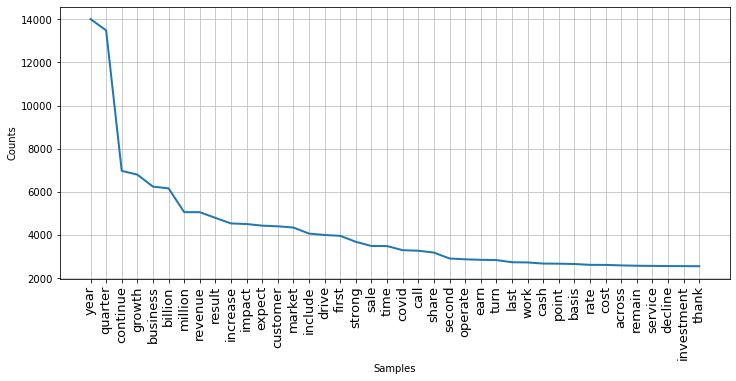

<Figure size 432x288 with 0 Axes>

In [13]:
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
#display top word frequency of the top 40 words
fd.plot(40,cumulative=False)

# Exports graph as a png image file
plt.savefig("Fig1Top40WordsPrepRemarks.png")

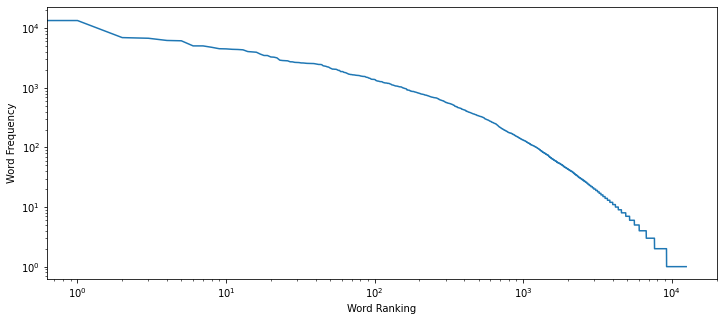

In [14]:
# log-log of all words
from collections import Counter
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Word Frequency")
plt.xlabel("Word Ranking")

# Exports graph as a png image file
plt.savefig("Fig2WordFreqandRankPrepRemarks.png")

In [15]:
#verify latest dataframe column output
transcribed_list.head()

,Unnamed: 0,date,ticker,title,transcript,transcript_prep_remarks,url,char_count,no_punctuation,preprocess_trans,clean_trans
0,0,10/29/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q4 2020 Resu...,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,"['Operator', 'Good day everyone and welcome to...",/article/4382943-apple-inc-aapl-ceo-tim-cook-o...,24264,Operator Good day everyone and welcome to the ...,operator good everyone welcome apple fourth qu...,operator good everyone welcome apple fourth qu...
1,1,7/30/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q3 2020 Resu...,Apple Inc. (NASDAQ:AAPL) Q3 2020 Results Confe...,"['Operator', ""Good day, everyone. Welcome to t...",/article/4362707-apple-inc-aapl-ceo-tim-cook-o...,22271,Operator Good day everyone Welcome to the Appl...,operator good everyone welcome apple incorpora...,operator good everyone welcome apple incorpora...
2,2,4/30/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q2 2020 Resu...,Apple Inc. (NASDAQ:AAPL) Q2 2020 Results Confe...,"['Operator', 'Good day everyone. Welcome to th...",/article/4341792-apple-inc-aapl-ceo-tim-cook-o...,25445,Operator Good day everyone Welcome to the Appl...,operator good everyone welcome apple incorpora...,operator good everyone welcome apple incorpora...
3,3,1/28/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q1 2020 Resu...,Apple Inc. (NASDAQ:AAPL) Q1 2020 Results Confe...,"['Operator', ""Good day, everyone. Welcome to t...",/article/4319666-apple-inc-aapl-ceo-tim-cook-o...,19795,Operator Good day everyone Welcome to the Appl...,operator good everyone welcome apple incorpora...,operator good everyone welcome apple incorpora...
4,8,10/30/2020,ABBV,AbbVie Inc.'s (ABBV) CEO Rick Gonzalez on Q3 2...,AbbVie Inc. (NYSE:ABBV) Q3 2020 Results Earnin...,"['Operator', 'Good morning and thank you for s...",/article/4383381-abbvie-inc-s-abbv-ceo-rick-go...,28731,Operator Good morning and thank you for standi...,operator good morning thank stand welcome abbv...,operator good morning thank stand welcome abbv...


In [16]:
#remove stop words
from sklearn.feature_extraction import text #import package

skl_stopwords = text.ENGLISH_STOP_WORDS
#print(skl_stopwords)

from nltk.corpus import stopwords # for excluding the stopwords

#creating an object using the default nltk stopwords
nltk_stopwords = stopwords.words("english")
print(nltk_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [17]:
#remove stop words from latest cleaned transcript
transcribed_list['clean_trans2']=transcribed_list['clean_trans'].apply(lambda x: " ".join(x for x in x.split() if x not in nltk_stopwords))
transcribed_list['clean_trans2'][:6]

0    operator good everyone welcome apple fourth qu...
1    operator good everyone welcome apple incorpora...
2    operator good everyone welcome apple incorpora...
3    operator good everyone welcome apple incorpora...
4    operator good morning thank stand welcome abbv...
5    operator good morning thank stand welcome abbv...
Name: clean_trans2, dtype: object

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# Now eliminaing customized stop words
count_vect = CountVectorizer(binary=False, stop_words = nltk_stopwords) 

count_vect_custom_stopwords = count_vect.fit_transform(transcribed_list['clean_trans2'])
print(count_vect_custom_stopwords.shape)
print(count_vect_custom_stopwords)

names = count_vect.get_feature_names()   
count = np.sum(count_vect_custom_stopwords.toarray(), axis = 0) 
count2 = count.tolist() 



(401, 12501)
  (0, 7774)	2
  (0, 4802)	4
  (0, 3960)	2
  (0, 12251)	1
  (0, 703)	35
  (0, 4469)	1
  (0, 8883)	46
  (0, 4308)	8
  (0, 12430)	40
  (0, 3519)	3
  (0, 2350)	1
  (0, 1652)	10
  (0, 11300)	8
  (0, 9102)	32
  (0, 11271)	30
  (0, 7760)	5
  (0, 9309)	2
  (0, 5806)	2
  (0, 11564)	3
  (0, 11087)	5
  (0, 4609)	3
  (0, 10037)	1
  (0, 563)	2
  (0, 2553)	1
  (0, 4275)	1
  :	:
  (400, 5078)	1
  (400, 4994)	4
  (400, 2811)	1
  (400, 1144)	3
  (400, 6599)	2
  (400, 11594)	2
  (400, 4548)	1
  (400, 1717)	1
  (400, 929)	1
  (400, 2768)	1
  (400, 3298)	2
  (400, 6025)	1
  (400, 3213)	1
  (400, 10468)	4
  (400, 3846)	1
  (400, 7375)	1
  (400, 2773)	1
  (400, 7071)	1
  (400, 9720)	2
  (400, 654)	1
  (400, 2155)	1
  (400, 1133)	1
  (400, 6016)	1
  (400, 1683)	1
  (400, 107)	1


In [19]:
#dataframe of output
count_df = pd.DataFrame(count2, index = names, columns = ['Word Count']) 
#  top 20 features by count
count_df.sort_values(['Word Count'], ascending = False)[:20]


,Word Count
year,14004
quarter,13484
continue,6973
growth,6799
business,6243
billion,6164
million,5062
revenue,5059
result,4795
increase,4538


In [21]:
# import SentimentIntensityAnalyzer class 
# from vaderSentiment.vaderSentiment module. 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [20]:
#VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in 
#social media and generalizes to multiple domains. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally 
#labelled according to their semantic orientation as either positive or negative.http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf
#VADER does not require training data and is constructed from a generalizable, valence-based, human curated standard sentiment lexicon

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def getSentimentScores(text):
    score=SentimentIntensityAnalyzer()
    #dictionary
    sentiment_dict=score.polarity_scores(text)
    print(sentiment_dict)
    print(f'positive sentiment: {sentiment_dict["pos"]*100}, %positive')
    print(f'neutral sentiment: {sentiment_dict["neu"]*100}, %neutral')
    print(f'negative sentiment: {sentiment_dict["neg"]*100}, %negative')
    #decide sentiment 
    if sentiment_dict['compound'] > 0.075:
        print ('Positive')
    elif sentiment_dict['compound'] < 0.025:
        print ('Negative')
    else: 
        print ('Neutral')
    return sentiment_dict

In [21]:
###modified 2
transcribed_list['sentiment_compound']=transcribed_list['clean_trans2'].apply(lambda x: getSentimentScores(x)['compound'])

{'neg': 0.05, 'neu': 0.706, 'pos': 0.245, 'compound': 0.9999}
positive sentiment: 24.5, %positive
neutral sentiment: 70.6, %neutral
negative sentiment: 5.0, %negative
Positive
{'neg': 0.042, 'neu': 0.7, 'pos': 0.258, 'compound': 0.9999}
positive sentiment: 25.8, %positive
neutral sentiment: 70.0, %neutral
negative sentiment: 4.2, %negative
Positive
{'neg': 0.041, 'neu': 0.728, 'pos': 0.231, 'compound': 0.9999}
positive sentiment: 23.1, %positive
neutral sentiment: 72.8, %neutral
negative sentiment: 4.1000000000000005, %negative
Positive
{'neg': 0.033, 'neu': 0.72, 'pos': 0.247, 'compound': 0.9999}
positive sentiment: 24.7, %positive
neutral sentiment: 72.0, %neutral
negative sentiment: 3.3000000000000003, %negative
Positive
{'neg': 0.031, 'neu': 0.714, 'pos': 0.256, 'compound': 1.0}
positive sentiment: 25.6, %positive
neutral sentiment: 71.39999999999999, %neutral
negative sentiment: 3.1, %negative
Positive
{'neg': 0.044, 'neu': 0.762, 'pos': 0.194, 'compound': 0.9999}
positive sentime

In [22]:
###modified 2
transcribed_list['sentiment_pos']=transcribed_list['clean_trans2'].apply(lambda x: getSentimentScores(x)['pos'])

{'neg': 0.05, 'neu': 0.706, 'pos': 0.245, 'compound': 0.9999}
positive sentiment: 24.5, %positive
neutral sentiment: 70.6, %neutral
negative sentiment: 5.0, %negative
Positive
{'neg': 0.042, 'neu': 0.7, 'pos': 0.258, 'compound': 0.9999}
positive sentiment: 25.8, %positive
neutral sentiment: 70.0, %neutral
negative sentiment: 4.2, %negative
Positive
{'neg': 0.041, 'neu': 0.728, 'pos': 0.231, 'compound': 0.9999}
positive sentiment: 23.1, %positive
neutral sentiment: 72.8, %neutral
negative sentiment: 4.1000000000000005, %negative
Positive
{'neg': 0.033, 'neu': 0.72, 'pos': 0.247, 'compound': 0.9999}
positive sentiment: 24.7, %positive
neutral sentiment: 72.0, %neutral
negative sentiment: 3.3000000000000003, %negative
Positive
{'neg': 0.031, 'neu': 0.714, 'pos': 0.256, 'compound': 1.0}
positive sentiment: 25.6, %positive
neutral sentiment: 71.39999999999999, %neutral
negative sentiment: 3.1, %negative
Positive
{'neg': 0.044, 'neu': 0.762, 'pos': 0.194, 'compound': 0.9999}
positive sentime

In [23]:
###modified 2
transcribed_list['sentiment_neg']=transcribed_list['clean_trans2'].apply(lambda x: getSentimentScores(x)['neg'])

{'neg': 0.05, 'neu': 0.706, 'pos': 0.245, 'compound': 0.9999}
positive sentiment: 24.5, %positive
neutral sentiment: 70.6, %neutral
negative sentiment: 5.0, %negative
Positive
{'neg': 0.042, 'neu': 0.7, 'pos': 0.258, 'compound': 0.9999}
positive sentiment: 25.8, %positive
neutral sentiment: 70.0, %neutral
negative sentiment: 4.2, %negative
Positive
{'neg': 0.041, 'neu': 0.728, 'pos': 0.231, 'compound': 0.9999}
positive sentiment: 23.1, %positive
neutral sentiment: 72.8, %neutral
negative sentiment: 4.1000000000000005, %negative
Positive
{'neg': 0.033, 'neu': 0.72, 'pos': 0.247, 'compound': 0.9999}
positive sentiment: 24.7, %positive
neutral sentiment: 72.0, %neutral
negative sentiment: 3.3000000000000003, %negative
Positive
{'neg': 0.031, 'neu': 0.714, 'pos': 0.256, 'compound': 1.0}
positive sentiment: 25.6, %positive
neutral sentiment: 71.39999999999999, %neutral
negative sentiment: 3.1, %negative
Positive
{'neg': 0.044, 'neu': 0.762, 'pos': 0.194, 'compound': 0.9999}
positive sentime

In [24]:
###modified 2
transcribed_list['sentiment_neu']=transcribed_list['clean_trans2'].apply(lambda x: getSentimentScores(x)['neu'])

{'neg': 0.05, 'neu': 0.706, 'pos': 0.245, 'compound': 0.9999}
positive sentiment: 24.5, %positive
neutral sentiment: 70.6, %neutral
negative sentiment: 5.0, %negative
Positive
{'neg': 0.042, 'neu': 0.7, 'pos': 0.258, 'compound': 0.9999}
positive sentiment: 25.8, %positive
neutral sentiment: 70.0, %neutral
negative sentiment: 4.2, %negative
Positive
{'neg': 0.041, 'neu': 0.728, 'pos': 0.231, 'compound': 0.9999}
positive sentiment: 23.1, %positive
neutral sentiment: 72.8, %neutral
negative sentiment: 4.1000000000000005, %negative
Positive
{'neg': 0.033, 'neu': 0.72, 'pos': 0.247, 'compound': 0.9999}
positive sentiment: 24.7, %positive
neutral sentiment: 72.0, %neutral
negative sentiment: 3.3000000000000003, %negative
Positive
{'neg': 0.031, 'neu': 0.714, 'pos': 0.256, 'compound': 1.0}
positive sentiment: 25.6, %positive
neutral sentiment: 71.39999999999999, %neutral
negative sentiment: 3.1, %negative
Positive
{'neg': 0.044, 'neu': 0.762, 'pos': 0.194, 'compound': 0.9999}
positive sentime

In [25]:
transcribed_list.head(3)


,Unnamed: 0,date,ticker,title,transcript,transcript_prep_remarks,url,char_count,no_punctuation,preprocess_trans,clean_trans,clean_trans2,sentiment_compound,sentiment_pos,sentiment_neg,sentiment_neu
0,0,10/29/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q4 2020 Resu...,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,"['Operator', 'Good day everyone and welcome to...",/article/4382943-apple-inc-aapl-ceo-tim-cook-o...,24264,Operator Good day everyone and welcome to the ...,operator good everyone welcome apple fourth qu...,operator good everyone welcome apple fourth qu...,operator good everyone welcome apple fourth qu...,0.9999,0.245,0.050,0.706
1,1,7/30/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q3 2020 Resu...,Apple Inc. (NASDAQ:AAPL) Q3 2020 Results Confe...,"['Operator', ""Good day, everyone. Welcome to t...",/article/4362707-apple-inc-aapl-ceo-tim-cook-o...,22271,Operator Good day everyone Welcome to the Appl...,operator good everyone welcome apple incorpora...,operator good everyone welcome apple incorpora...,operator good everyone welcome apple incorpora...,0.9999,0.258,0.042,0.700
2,2,4/30/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q2 2020 Resu...,Apple Inc. (NASDAQ:AAPL) Q2 2020 Results Confe...,"['Operator', 'Good day everyone. Welcome to th...",/article/4341792-apple-inc-aapl-ceo-tim-cook-o...,25445,Operator Good day everyone Welcome to the Appl...,operator good everyone welcome apple incorpora...,operator good everyone welcome apple incorpora...,operator good everyone welcome apple incorpora...,0.9999,0.231,0.041,0.728


In [27]:
transcribed_list.columns

Index(['Unnamed: 0', 'date', 'ticker', 'title', 'transcript',
       'transcript_prep_remarks', 'url', 'char_count', 'no_punctuation',
       'preprocess_trans', 'clean_trans', 'clean_trans2', 'sentiment_compound',
       'sentiment_pos', 'sentiment_neg', 'sentiment_neu'],
      dtype='object')

In [26]:
transcribed_list[['sentiment_pos', 'sentiment_neg', 'sentiment_neu']].describe()

,sentiment_pos,sentiment_neg,sentiment_neu
count,401.000000,401.000000,401.000000
mean,0.234793,0.044287,0.688504
std,0.056453,0.020496,0.130239
min,0.000000,0.000000,0.000000
25%,0.216000,0.031000,0.689000
50%,0.242000,0.043000,0.709000
75%,0.266000,0.058000,0.730000
max,0.355000,0.101000,0.841000


In [27]:
transcribed_list_sent= transcribed_list.drop(['Unnamed: 0','transcript','transcript_prep_remarks', 'url', 'char_count', 'no_punctuation',
       'preprocess_trans', 'clean_trans', 'sentiment_compound'],1)

transcribed_list_sent.head(3)     

,date,ticker,title,clean_trans2,sentiment_pos,sentiment_neg,sentiment_neu
0,10/29/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q4 2020 Resu...,operator good everyone welcome apple fourth qu...,0.245,0.050,0.706
1,7/30/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q3 2020 Resu...,operator good everyone welcome apple incorpora...,0.258,0.042,0.700
2,4/30/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q2 2020 Resu...,operator good everyone welcome apple incorpora...,0.231,0.041,0.728


In [28]:
transcribed_list_sent.to_csv('transcript_prep_remarks_Vader_sents.csv')

In [ ]:
#if already saved read the csv with stored sentiments from Vader
trans_Vader_sents = pd.read_csv('transcript_prep_remarks_Vader_sents.csv')

In [29]:
transcribed_list_sent[['sentiment_neu',
       'sentiment_neg', 'sentiment_pos']].describe()

,sentiment_neu,sentiment_neg,sentiment_pos
count,401.000000,401.000000,401.000000
mean,0.688504,0.044287,0.234793
std,0.130239,0.020496,0.056453
min,0.000000,0.000000,0.000000
25%,0.689000,0.031000,0.216000
50%,0.709000,0.043000,0.242000
75%,0.730000,0.058000,0.266000
max,0.841000,0.101000,0.355000


In [30]:
#read list of words for positive and negative descriptors from a high level language dictionary
HLpos = [line.strip() for line in  open('HLpos.txt','r')]
HLneg = [line.strip() for line in  open('HLneg.txt','r',encoding = 'latin-1')]
print("HL pos  size: " + str(len(HLpos)))
print(HLpos[0:10])
print("HL neg  size: " + str(len(HLneg)))
print(HLneg[0:10])

HL pos  size: 2006
['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']
HL neg  size: 4783
['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted']


In [31]:
# depending on word count assign a tone across the scores from words in the dictionary
def hl_sent(inputstring):
    poscount = 0
    negcount = 0
    for word in inputstring.split(): 
        if HLpos.count(word.rstrip('?:!.,;')):
            poscount +=1
        elif HLneg.count(word.rstrip('?:!.,;')):
            negcount +=1
    if poscount+negcount > 0:
        t = float((poscount - negcount)/(poscount+negcount))    
    else:
        t = 0
    #set tone based on mean of summary of scores in .describe above
    if t > 0.20:
        tone = "Positive"
    elif t < 0.04:
        tone = "Negative"
    else:
        tone = "Neutral"
    return tone

In [32]:
#takes a little longer - needs to check multiple lists
transcribed_list_sent['sentimentsHL'] = transcribed_list_sent.clean_trans2.apply(lambda x: hl_sent(x))
#then use following code to see both columns 
transcribed_list_sent.iloc[0:10][['clean_trans2', 
       'sentiment_pos', 'sentiment_neg', 'sentiment_neu']]



,clean_trans2,sentiment_pos,sentiment_neg,sentiment_neu
0,operator good everyone welcome apple fourth qu...,0.245,0.050,0.706
1,operator good everyone welcome apple incorpora...,0.258,0.042,0.700
2,operator good everyone welcome apple incorpora...,0.231,0.041,0.728
3,operator good everyone welcome apple incorpora...,0.247,0.033,0.720
4,operator good morning thank stand welcome abbv...,0.256,0.031,0.714
5,operator good morning thank stand welcome abbv...,0.194,0.044,0.762
6,operator good morning thank stand welcome abbv...,0.198,0.066,0.735
7,operator good morning thank stand welcome abbv...,0.236,0.049,0.715
8,operator good morning thank stand welcome abbo...,0.236,0.043,0.721
9,operator good morning thank stand welcome abbo...,0.224,0.056,0.721


In [33]:
transcribed_list_sent['sentimentsHL'].value_counts()

Positive    374
Negative     16
Neutral      11
Name: sentimentsHL, dtype: int64

In [34]:
#delete
transcribed_list_sent

,date,ticker,title,clean_trans2,sentiment_pos,sentiment_neg,sentiment_neu,sentimentsHL
0,10/29/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q4 2020 Resu...,operator good everyone welcome apple fourth qu...,0.245,0.050,0.706,Positive
1,7/30/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q3 2020 Resu...,operator good everyone welcome apple incorpora...,0.258,0.042,0.700,Positive
2,4/30/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q2 2020 Resu...,operator good everyone welcome apple incorpora...,0.231,0.041,0.728,Positive
3,1/28/2020,AAPL,Apple Inc. (AAPL) CEO Tim Cook on Q1 2020 Resu...,operator good everyone welcome apple incorpora...,0.247,0.033,0.720,Positive
4,10/30/2020,ABBV,AbbVie Inc.'s (ABBV) CEO Rick Gonzalez on Q3 2...,operator good morning thank stand welcome abbv...,0.256,0.031,0.714,Positive
...,...,...,...,...,...,...,...,...
396,5/19/2020,WMT,"Walmart, Inc. (WMT) CEO Doug McMillon on Q1 20...",,0.000,0.000,0.000,Negative
397,10/30/2020,XOM,Exxon Mobil Corporation (XOM) Q3 2020 Results ...,operator good everyone welcome exxon mobil cor...,0.210,0.069,0.721,Positive
398,7/31/2020,XOM,Exxon Mobil Corp (XOM) Q2 2020 Results - Earni...,operator good everyone welcome exxon mobil cor...,0.200,0.077,0.723,Positive
399,5/1/2020,XOM,Exxon Mobil Corporation (XOM) CEO Darren Woods...,operator good everyone welcome exxon mobil cor...,0.218,0.074,0.708,Positive


In [35]:
#read list of words for positive and negative descriptors in the Loughran and McDonald Sentiment Word Lists.
#The essential method of textual analysis goes by various labels in other disciplines such as content analysis, natural 
#language processing, information retrieval, or computational linguistics.  A growing literature finds significant relations 
#between stock price reactions and the sentiment of information releases as measured by word classifications.
#https://sraf.nd.edu/textual-analysis/resources/#Master%20Dictionary
LMpos = [line.strip() for line in  open('LoughranMcDonald_PositiveList.txt','r')]
LMneg = [line.strip() for line in  open('LoughranMcDonald_NegativeList.txt','r',encoding = 'latin-1')]
print("LM pos  size: " + str(len(LMpos)))
print(LMpos[0:10])
print("LM neg  size: " + str(len(LMneg)))
print(LMneg[0:10])

LM pos  size: 354
['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes', 'accomplishing', 'accomplishment', 'accomplishments']
LM neg  size: 2355
['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated', 'abdicates', 'abdicating', 'abdication']


In [36]:
def LM_sent(inputstring):
    poscount = 0
    negcount = 0
    for word in inputstring.split(): 
        if LMpos.count(word.rstrip('?:!.,;')):
            poscount +=1
        elif LMneg.count(word.rstrip('?:!.,;')):
            negcount +=1
    if poscount+negcount > 0:
        t = float((poscount - negcount)/(poscount+negcount))    
    else:
        t = 0
    if t > 0.20:
        tone = "Positive"
    elif t < 0.04:
        tone = "Negative"
    else:
        tone = "Neutral"
    return tone

In [37]:
transcribed_list_sent['sentimentsLM'] = transcribed_list_sent.clean_trans2.apply(lambda x: LM_sent(x))

In [38]:
transcribed_list_sent.tail(3)

,date,ticker,title,clean_trans2,sentiment_pos,sentiment_neg,sentiment_neu,sentimentsHL,sentimentsLM
398,7/31/2020,XOM,Exxon Mobil Corp (XOM) Q2 2020 Results - Earni...,operator good everyone welcome exxon mobil cor...,0.200,0.077,0.723,Positive,Neutral
399,5/1/2020,XOM,Exxon Mobil Corporation (XOM) CEO Darren Woods...,operator good everyone welcome exxon mobil cor...,0.218,0.074,0.708,Positive,Negative
400,1/31/2020,XOM,Exxon Mobil Corporation (XOM) CEO Darren Woods...,operator good everyone welcome exxon mobil cor...,0.260,0.055,0.685,Positive,Positive


In [39]:
transcribed_list_sent.to_csv('transcript_prerp_VadernHLLM_sents.csv')